In [49]:
import pandas as pd
import numpy as np 
from numpy import random

data = pd.read_csv('data/result.csv',parse_dates=['time'], index_col=['time'])
train_data = data.loc['2017-07-04 00:00:00':'2017-07-13 03:55:00']
test_data = data.loc['2017-07-13 04:00:00':'2017-07-17 21:15:00']
# data = data[52992:56992]
# data = data.reset_index(drop=True)
data

,outdoor_temp,zone_temp,occupancy,supply_temp,air_flow
time,,,,,
2017-01-01 00:00:00,2.200,22.832449,0,25.000003,0.733767
2017-01-01 00:05:00,1.825,22.824465,0,25.000003,0.733767
2017-01-01 00:10:00,1.450,22.812760,0,25.000003,0.733767
2017-01-01 00:15:00,1.075,22.799019,0,25.000003,0.733767
2017-01-01 00:20:00,0.700,22.784421,0,25.000003,0.733767
...,...,...,...,...,...
2017-12-31 23:40:00,6.000,22.990503,0,25.000004,0.733767
2017-12-31 23:45:00,6.000,22.988552,0,25.000004,0.733767
2017-12-31 23:50:00,6.000,22.986715,0,25.000004,0.733767


In [38]:
##Faults:
# 1. Offset Fault: x' = a + x + err
# 2. Gain Fault: x' = Bx+ err
# 3. Stuck at Fault: x' = a
# 4. Out-of-bound: x'<theta1 and x'>theta2

def simulateFault(sensedValues, params):
    end_fault_index = int(len(sensedValues) * 0.5)
    interval = end_fault_index/4
    BMS = []
    classification = []
    
    noise = random.rand(len(sensedValues)) * 0.5
    for i in range(0, len(sensedValues)):
        if i <= interval:
            a = params['constant']
            sign = random.randint(1,3)
            if sign == 1:
                BMS.append(noise[i] + a + sensedValues[i])
            else:
                BMS.append(-noise[i] + a + sensedValues[i])
            classification.append(1)

        elif i > interval and i <= interval*2:
            B = params['coeff']
            sign = random.randint(1,3)
            if sign == 1:
                BMS.append(noise[i] + B * sensedValues[i])
            else:
                BMS.append(-noise[i] + B * sensedValues[i])
            classification.append(1)

        elif i > interval*2 and i<= interval*3:
            a = params['stuck']
            BMS.append(a)
            classification.append(1)
            
        elif i > interval*3 and i<= interval*4:
            type_fault = random.randint(1,3)
            low_bound = params['bounds'][0]
            up_bound = params['bounds'][1]
            if type_fault == 1:
                BMS.append(low_bound-noise[i])
            else:
                BMS.append(up_bound + noise[i])
            classification.append(1)
        else:
            BMS.append(noise[i] + sensedValues[i])
            classification.append(0)

    BMS = np.array(BMS)
    BMS = BMS.round(decimals = 3)
    sensedValues = sensedValues.round(decimals=3)
    return np.array(BMS), np.array(classification)


In [39]:
def sample_vectors(vectors, fault_rate):
    result_x = []
    result_y = []
    end_fault_index1 = int(len(vectors) * 0.5)
    end_fault_index = int(len(vectors) * fault_rate)
    interval = end_fault_index1/4
    for i in range(0, end_fault_index):
        fault = random.randint(0, int(len(vectors)*0.5))
        result_x.append([vectors['lag_1'][fault],vectors['lag_2'][fault],vectors['lag_3'][fault],vectors['lag_4'][fault],vectors['lag_5'][fault],vectors['lag_6'][fault]])
        # if fault <= interval:
        #     result_y.append(1)

        # elif fault > interval and fault <= interval*2:
        #     result_y.append(2)

        # elif fault > interval*2 and fault<= interval*3:
        #     result_y.append(3)
            
        # elif fault > interval*3 and fault<= interval*4:
        #     result_y.append(4)
        result_y.append(1)
    for i in range(len(result_x),len(vectors)):
        fault = random.randint(int(len(vectors)*0.5),len(vectors))
        result_x.append([vectors['lag_1'][fault],vectors['lag_2'][fault],vectors['lag_3'][fault],vectors['lag_4'][fault],vectors['lag_5'][fault],vectors['lag_6'][fault]])
        result_y.append(0)
    print(len(result_x))
    return result_x, result_y

In [48]:
#Import svm model
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

rates = [0.1,0.2,0.3,0.4,0.5]

i = 0.1

acc = []
offset = []
gain = []
stuck = []
out_bounds = []

# train_data = data[0:2640]
# test_data = data[2640:4000]

supply_temp_train = train_data.drop(['outdoor_temp', 'zone_temp','occupancy','air_flow'], axis=1)
stuck_val = random.randint(16,32)

FaultData, classification = simulateFault(supply_temp_train['supply_temp'],{'constant': 3, 'coeff': 1.5, 'stuck': stuck_val, 'bounds': [14,60]})
#print(classification)
supply_temp_train['supply_temp_BMS'] = FaultData
#supply_temp_train['classification'] = classification
supply_temp_train['lag_1'] = supply_temp_train['supply_temp'].shift(1)
supply_temp_train['lag_2'] = supply_temp_train['supply_temp_BMS'].shift(1)
supply_temp_train['lag_3'] = supply_temp_train['supply_temp'].shift(2)
supply_temp_train['lag_4'] = supply_temp_train['supply_temp_BMS'].shift(2)
supply_temp_train['lag_5'] = supply_temp_train['supply_temp'].shift(3)
supply_temp_train['lag_6'] = supply_temp_train['supply_temp_BMS'].shift(3)
supply_temp_train = supply_temp_train[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
supply_temp_train = supply_temp_train.dropna()
x_train = supply_temp_train[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
y_train = classification[0:len(classification)-3]#supply_temp_train[['classification']]

#Create a svm Classifier
clf = svm.SVC(kernel='rbf', C = 1, gamma = 0.6) # Linear Kernel

#Train the model using the training sets
clf.fit(x_train, y_train)

while i <= 0.5:
    supply_temp_test = test_data.drop(['outdoor_temp', 'zone_temp','occupancy','air_flow'], axis=1)
    stuck_val = random.randint(16,32)
    #print(stuck_val)

    FaultData, classification = simulateFault(supply_temp_test['supply_temp'], {'constant': 4, 'coeff':1.7, 'stuck': stuck_val,'bounds': [14,60]})

    supply_temp_test['supply_temp_BMS'] = FaultData
    #supply_temp_test['classification'] = classification[2:len(classification)]
    supply_temp_test['lag_1'] = supply_temp_test['supply_temp'].shift(1)
    supply_temp_test['lag_2'] = supply_temp_test['supply_temp_BMS'].shift(1)
    supply_temp_test['lag_3'] = supply_temp_test['supply_temp'].shift(2)
    supply_temp_test['lag_4'] = supply_temp_test['supply_temp_BMS'].shift(2)
    supply_temp_test['lag_5'] = supply_temp_test['supply_temp'].shift(3)
    supply_temp_test['lag_6'] = supply_temp_test['supply_temp_BMS'].shift(3)
    supply_temp_test = supply_temp_test[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
    supply_temp_test = supply_temp_test.dropna()
    x_test = supply_temp_test[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
    y_test = classification[0:len(classification)-3]#supply_temp_test[['classification']]
    x_test = x_test.reset_index(drop=True)
    # print(x_test[675:685])
    # print(y_test[675:685])
    #x_test = prepare_data(BMS, sensor_reading)
    vectors, y_test = sample_vectors(x_test, i)
    #print(vectors)
    #x_test, y_test = process_data(vectors, [14,60])
    print(x_test)
    #print(y_test)
    x_test = np.array(vectors)
    y_test = np.array(y_test)
    
    y_pred = clf.predict(x_test)
    #scores = cross_val_score(clf, np.concatenate((x_train, x_test), axis=0), np.concatenate((y_train, y_test), axis=0), cv=5)
    #print(scores)
    #target_names = ['No Fault', 'Offset', 'Gain', 'Stuck','Out of Bounds']
    
    target_names = ['class 0', 'class 1']
    #print('FOR rate: ',i)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    #print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=target_names))
    column_sum = cnf_matrix.sum(axis = 1)
    #print(column_sum)
    acc.append(cnf_matrix[1][1] / column_sum[1])
    # offset.append(cnf_matrix[1][1] / column_sum[1] )
    # gain.append(cnf_matrix[2][2] / column_sum[2])
    # stuck.append(cnf_matrix[3][3] / column_sum[3])
    # out_bounds.append(cnf_matrix[3][3] / column_sum[3])
        
    #print(acc)
    i = i + 0.1 


1357
          lag_1   lag_2      lag_3   lag_4      lag_5   lag_6
0     24.999994  29.031  23.907080  27.572  24.999994  28.793
1     23.909545  27.496  24.999994  29.031  23.907080  27.572
2     24.999994  28.726  23.909545  27.496  24.999994  29.031
3     23.911698  28.079  24.999994  28.726  23.909545  27.496
4     24.999995  29.290  23.911698  28.079  24.999994  28.726
...         ...     ...        ...     ...        ...     ...
1352  23.635610  24.024  23.611909  23.851  23.586457  23.654
1353  23.657709  24.050  23.635610  24.024  23.611909  23.851
1354  23.678341  23.885  23.657709  24.050  23.635610  24.024
1355  23.765498  23.895  23.678341  23.885  23.657709  24.050
1356  23.799238  24.087  23.765498  23.895  23.678341  23.885

[1357 rows x 6 columns]
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00      1222
     class 1       0.99      1.00      0.99       135

    accuracy                           1.00      1357
   macro

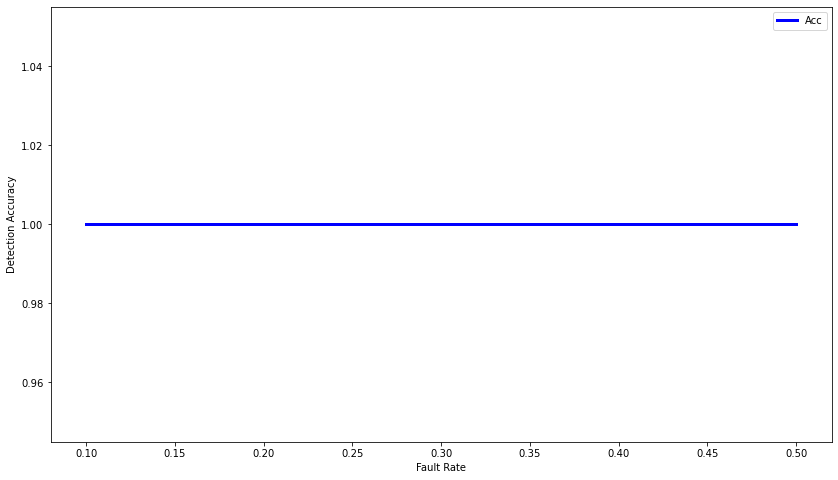

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(rates, acc, "blue", linewidth=3, label = 'Acc')
# ax.plot(rates, offset, "red", linewidth=6, label='offset', alpha = 0.3)
# ax.plot(rates, gain, "blue", linewidth=3, label = 'gain')
# ax.plot(rates, stuck, "green", linewidth=3, label = 'stuck')
# ax.plot(rates, out_bounds, "purple", linewidth=3, label = 'Out of Bounds')
ax.set_ylabel('Detection Accuracy')
ax.set_xlabel('Fault Rate')
fig.set_size_inches(14, 8)
plt.legend()
plt.show()

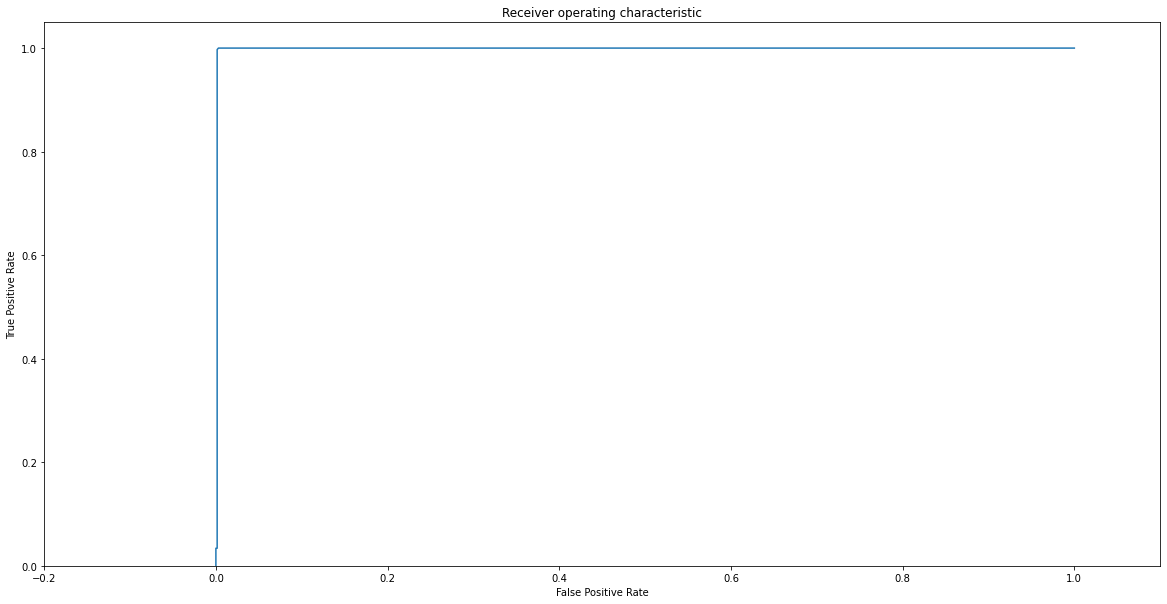

In [47]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = clf.decision_function(x_test)
# print(clf.score(x_train, y_train, sample_weight=None))
# print(probs)
for i in range(2):
    fpr[i], tpr[i], _ =  roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(20,10))
#plt.plot(fpr[1], tpr[1])
plt.plot(fpr[1], tpr[1])
plt.xlim([-0.2, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()